In [1]:
import numpy as np
import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time

# Verification of simulation by testing

\begin{array}{|l|l|l|}
\hline ID & Test name & Description \\
\hline 1 & \text { Fixed (0.0) } & \text { Top wheel 0, Yaw target 0 } \\
\hline 2 & \text { Fixed (0.0) } & \text { Top wheel 0, Yaw target 0 } \\
\hline 3 & \text { Fixed (6.0) } & \text { Top wheel 6, Yaw target 0 } \\
\hline 4 & \text { Fixed (-6.0) } & \text { Top wheel -6, Yaw target 0 } \\
\hline 5 & \text { Fixed (9.0) } & \text { Top wheel 9, Yaw target 0 } \\
\hline 6 & \text { Fixed (-9.0) } & \text { Top wheel -9, Yaw target 0 } \\
\hline 7 & \text { Fixed (0.5) } & \text { Top wheel 0, Yaw target 3 } \\
\hline 8 & \text { Fixed (0.-5) } & \text { Top wheel 0, Yaw target -3 } \\
\hline 9 & \text { Fixed (-6.-5) } & \text { Top wheel -6, Yaw target -3 } \\
\hline
\end{array}

All tests are done with constant X-velocity: 0.05 m/s

## Simulation

In [2]:
# Load simulation data
def df_sim(bag_name):
    b_sim = bagreader(bag_name)

    ODOM_SIM = b_sim.message_by_topic('/rr_robot/odom')
    SCAN_SIM = b_sim.message_by_topic('/scan')
    VEL_SIM = b_sim.message_by_topic('/velX')
    YAW_SIM = b_sim.message_by_topic('/yaw')
    JOINT_SIM = b_sim.message_by_topic('/rr_robot/joint_states')

    df_odom = pd.read_csv(ODOM_SIM)
    df_scan = pd.read_csv(SCAN_SIM)
    df_vel = pd.read_csv(VEL_SIM)
    df_yaw = pd.read_csv(YAW_SIM)
    df_joint = pd.read_csv(JOINT_SIM)

    # Check minimum distance as observed by the fake laser
    df_ranges = df_scan.drop(df_scan.iloc[:, 1:12],axis = 1)
    df_le_dist = df_scan.drop(df_scan.iloc[:, 1:],axis = 1)
    ranges_min = df_ranges.min(axis=1)
    df_le_dist['ranges_min'] = ranges_min

    return df_vel, df_yaw, df_odom, df_joint

In [3]:
n_sims = 4

mu_list = [0.5, 0.4, 0.3, 0.25]

df_vel_1, df_yaw_1, df_odom_1, df_joint_1 = df_sim('rosbag_sim/sim1_mu5.bag')
df_vel_2, df_yaw_2, df_odom_2, df_joint_2 = df_sim('rosbag_sim/sim1_mu4.bag')
df_vel_3, df_yaw_3, df_odom_3, df_joint_3 = df_sim('rosbag_sim/sim1_mu3.bag')
df_vel_4, df_yaw_4, df_odom_4, df_joint_4 = df_sim('rosbag_sim/sim1_mu25.bag')

df_vel = [df_vel_1, df_vel_2, df_vel_3, df_vel_4]
df_yaw = [df_yaw_1, df_yaw_2, df_yaw_3, df_yaw_4]
df_odom = [df_odom_1, df_odom_2, df_odom_3, df_odom_4]
df_joint = [df_joint_1, df_joint_2, df_joint_3, df_joint_4]

[INFO]  Data folder rosbag_sim/sim1_mu5 already exists. Not creating.
[INFO]  Data folder rosbag_sim/sim1_mu4 already exists. Not creating.
[INFO]  Data folder rosbag_sim/sim1_mu3 already exists. Not creating.
[INFO]  Data folder rosbag_sim/sim1_mu25 already exists. Not creating.


In [4]:
# Plot vel, yaw, le_dist
def df_plot(df_vel_, df_yaw_, df_odom_, df_joint_, title=''):

    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8,8), sharex=True)

    df_vel_['Time'] = df_vel_['Time'] - df_vel_['Time'].iat[0]
    df_yaw_['Time'] = df_yaw_['Time'] - df_yaw_['Time'].iat[0]
    df_odom_['Time'] = df_odom_['Time'] - df_odom_['Time'].iat[0]
    df_joint_['Time'] = df_joint_['Time'] - df_joint_['Time'].iat[0]

    df_yaw_deg = df_yaw_.copy()
    df_joint_deg = df_joint_.copy()

    df_yaw_deg['data'] = df_yaw_deg['data']*180/3.14
    df_joint_deg['position_13'] = df_joint_deg['position_13']*180/3.14
    df_joint_deg['position_14'] = df_joint_deg['position_14']*180/3.14

    df_odom_['pose.pose.position.y'] = df_odom_['pose.pose.position.y'] - df_odom_['pose.pose.position.y'].iat[0]

    df_vel_.plot(ylim=[-0.01,0.12], x='Time', xlabel='Time [s]', y='data', ylabel='x-velocity [m/s]', grid=True, legend=False, ax=axes[0], title=title)
    df_yaw_deg.plot(x='Time', xlabel='Time [s]', y='data', ylabel='Yaw [$^\circ$]', grid=True, legend=False, ax=axes[1])
    df_joint_deg.plot(ylim=[-10, 10], x='Time', xlabel='Time [s]', y='position_13', ylabel='Steering LE [$^\circ$]', grid=True, legend=False, ax=axes[2])
    df_joint_deg.plot(ylim=[-10, 10], x='Time', xlabel='Time [s]', y='position_14', ylabel='Steering TE [$^\circ$]', grid=True, legend=False, ax=axes[3])
    df_odom_.plot(x='Time', xlabel='Time [s]', y='pose.pose.position.y', ylabel='y-position [m]', legend=False, grid=True, ax=axes[4])

### Finding mu for the wheels

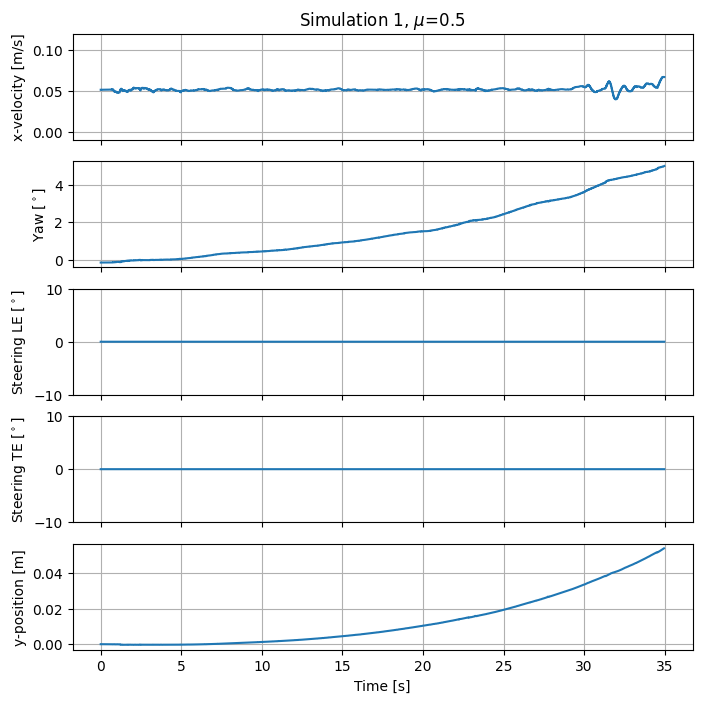

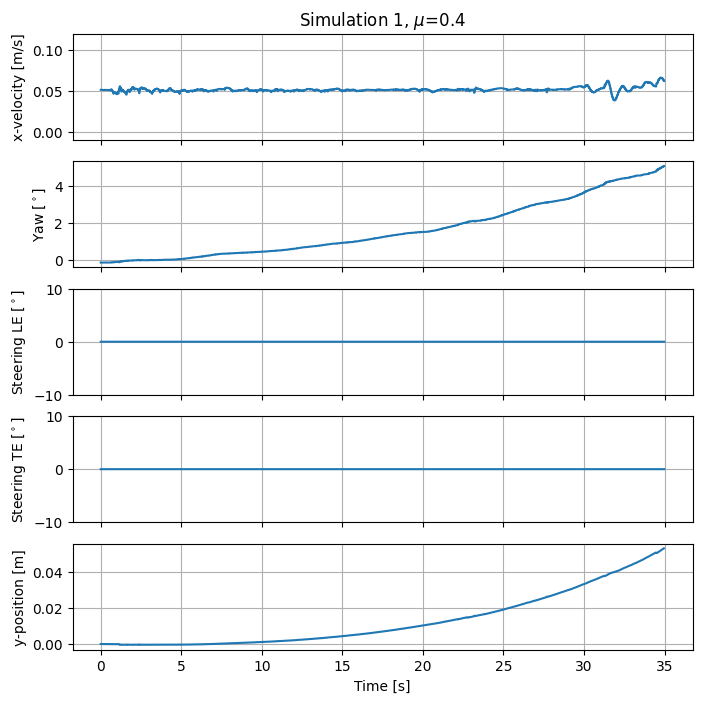

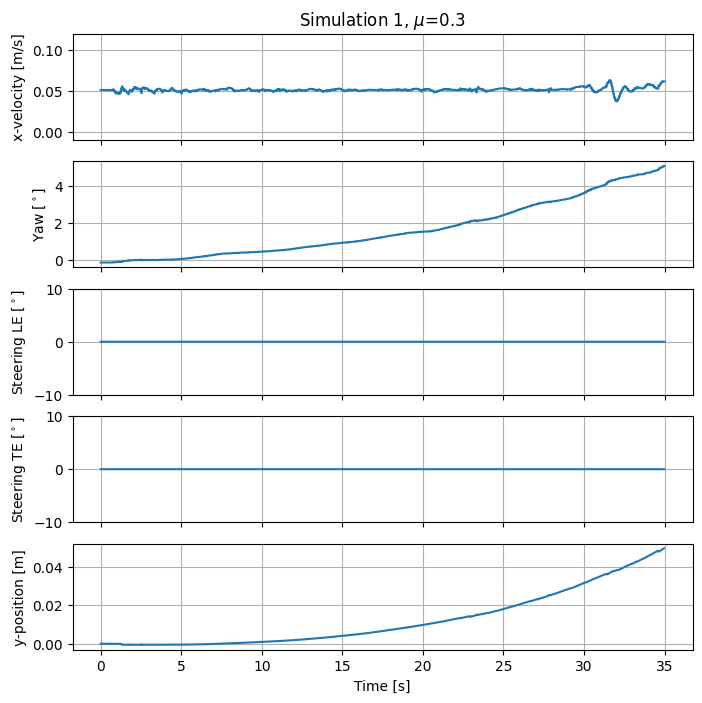

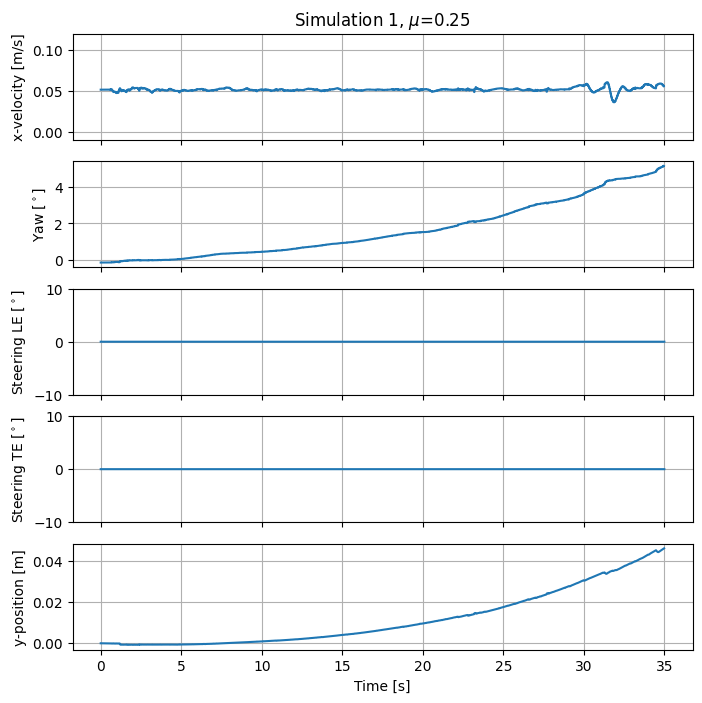

In [5]:
for i in range(0, n_sims):
    df_plot(df_vel[i], df_yaw[i], df_odom[i], df_joint[i], title=f'Simulation 1, $\mu$={mu_list[i]}')
    plt.savefig(f'plots/sim1_mu{mu_list[i]}.png', bbox_inches='tight')

### Running simulations with found mu

In [6]:
#off_set = [[0,-0.01], [5,-0.01], [0.5,0], [0,0], [0,0], [1,0.01], [1,-0.01], [4.5,0], [0,-0.1]]

#no = 5

#df_vel_1, df_yaw_1, df_odom_1, df_joint_1 = df_sim(f'rosbag_sim/sim{no}.bag')

#df_plot(df_vel_1, df_yaw_1, df_odom_1, df_joint_1, title=f'Simulation')

#df_plot_y_offset(test_starts[no-1], test_ends[no-1], df_le_dist_exp, df_odom_1, off_set[no-1], title=f'Comparison, $\mu=0.25$')

[INFO]  Data folder rosbag_sim/sim1 already exists. Not creating.
[INFO]  Data folder rosbag_sim/sim2 already exists. Not creating.
[INFO]  Data folder rosbag_sim/sim3 already exists. Not creating.
[INFO]  Data folder rosbag_sim/sim4 already exists. Not creating.
[INFO]  Data folder rosbag_sim/sim5 already exists. Not creating.
[INFO]  Data folder rosbag_sim/sim6 already exists. Not creating.
[INFO]  Data folder rosbag_sim/sim7 already exists. Not creating.
[INFO]  Data folder rosbag_sim/sim8 already exists. Not creating.
[INFO]  Data folder rosbag_sim/sim9 already exists. Not creating.


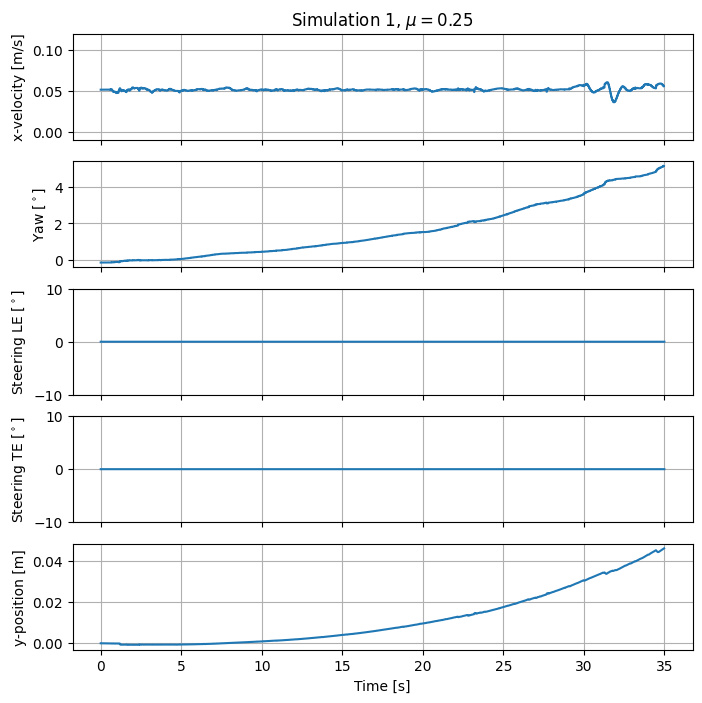

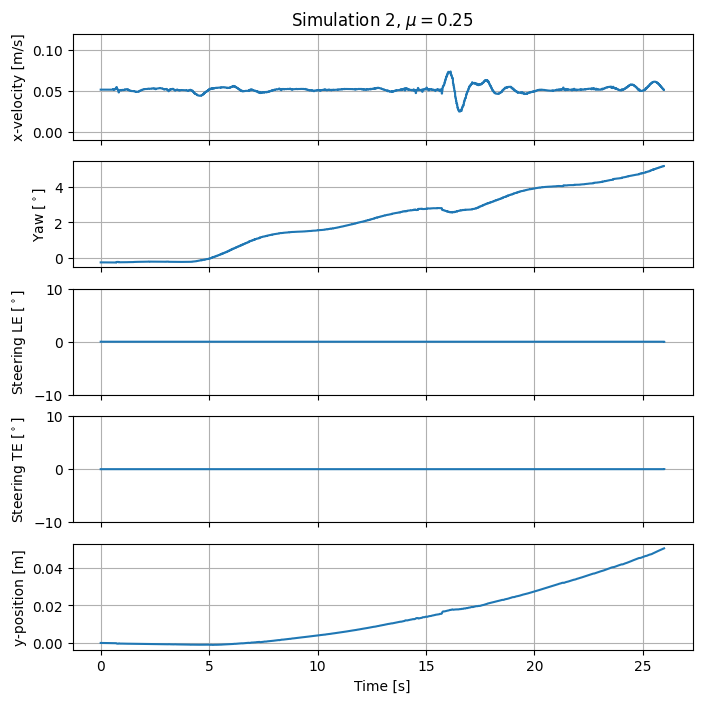

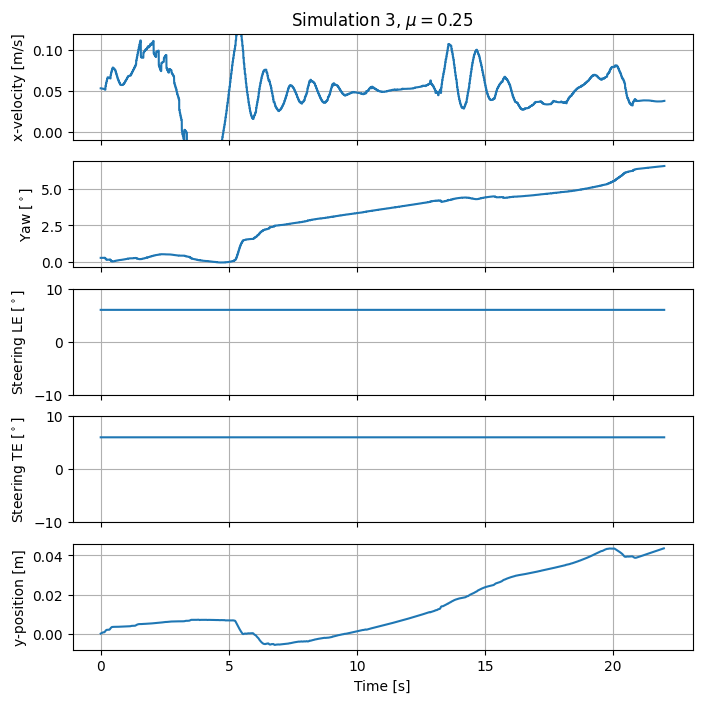

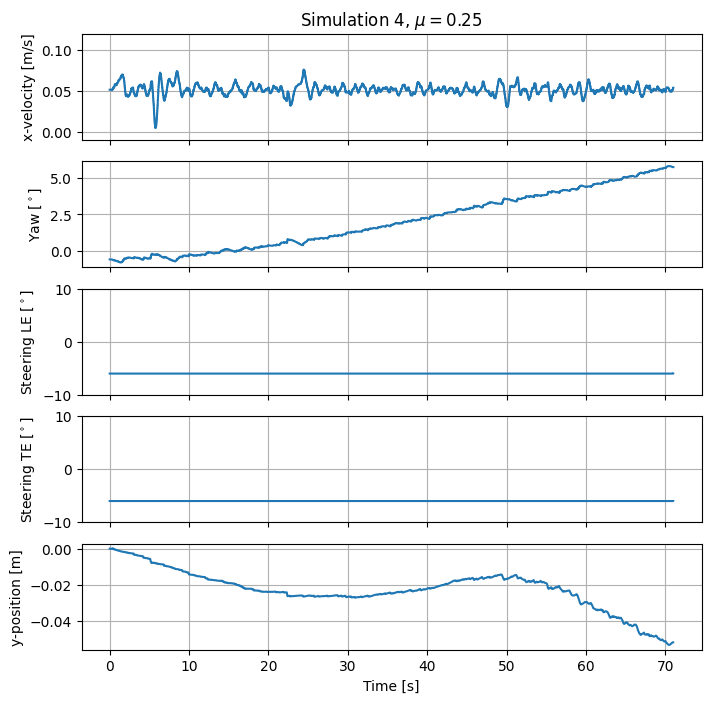

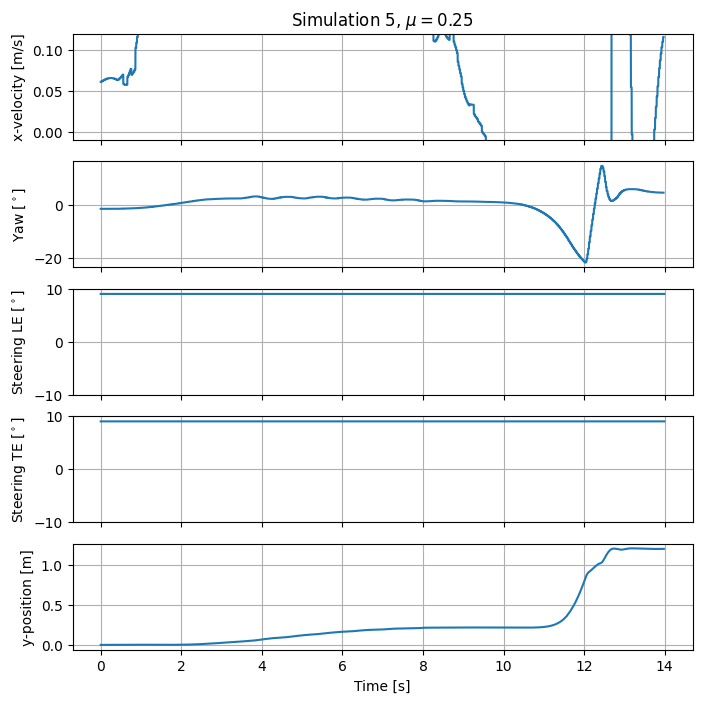

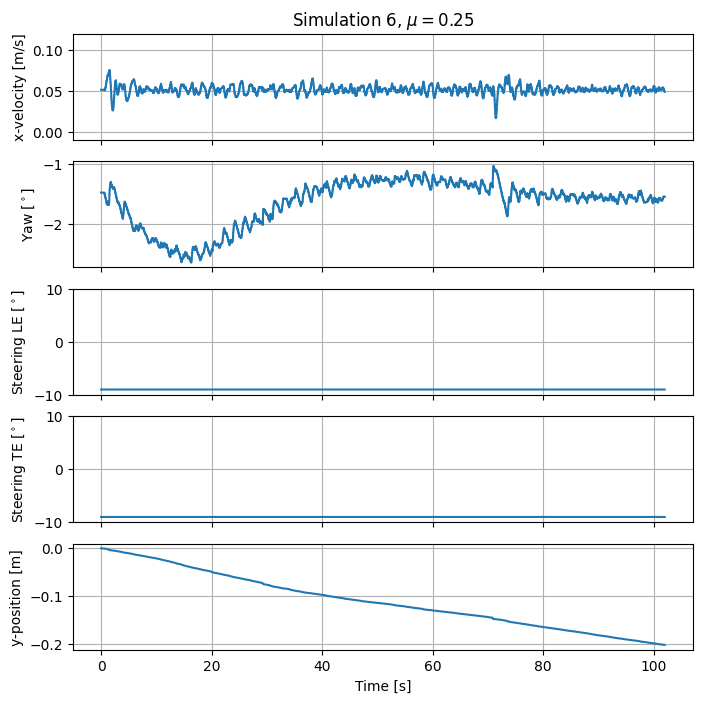

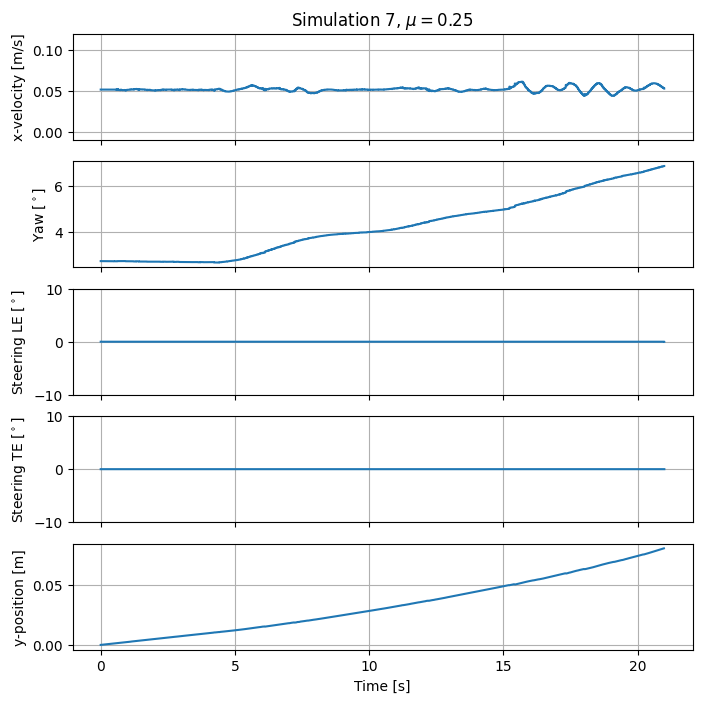

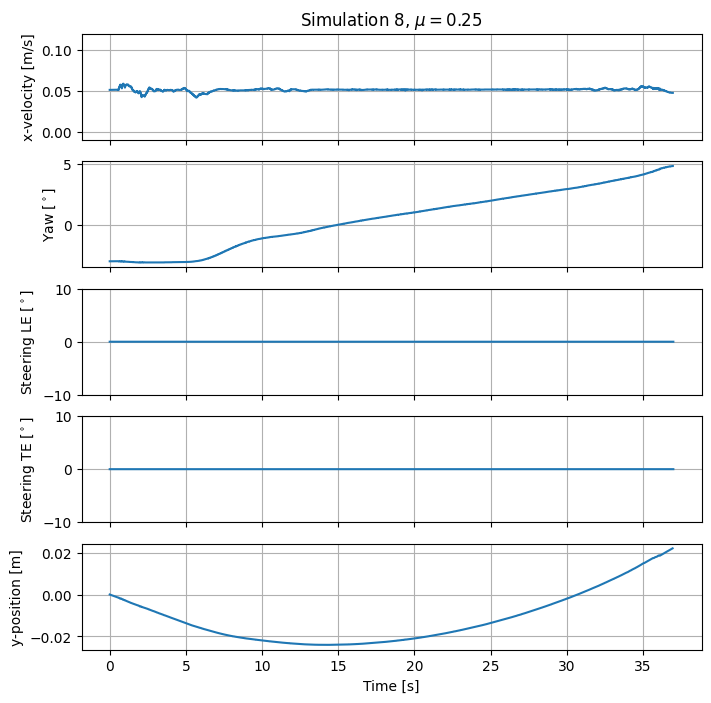

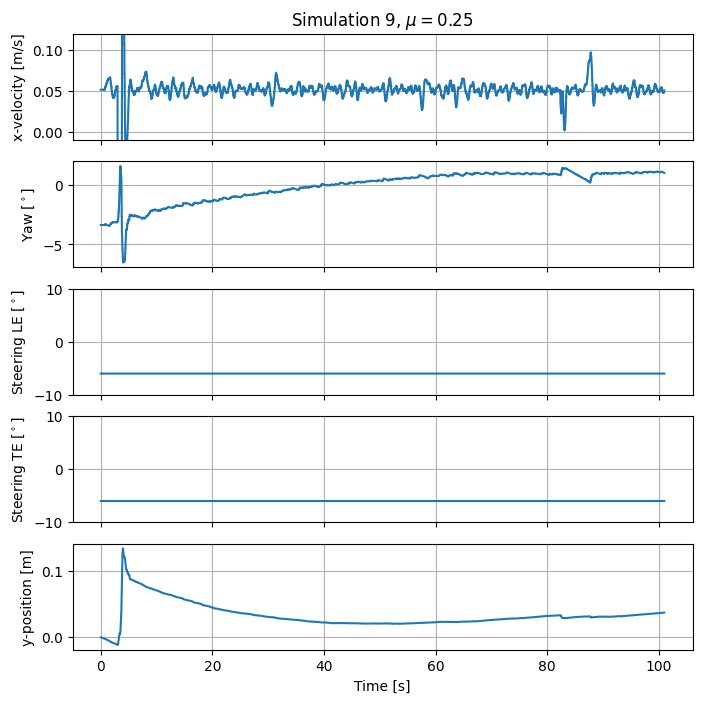

In [7]:
n_sims = 9

df_vel_1, df_yaw_1, df_odom_1, df_joint_1 = df_sim('rosbag_sim/sim1.bag')
df_vel_2, df_yaw_2, df_odom_2, df_joint_2 = df_sim('rosbag_sim/sim2.bag')
df_vel_3, df_yaw_3, df_odom_3, df_joint_3 = df_sim('rosbag_sim/sim3.bag')
df_vel_4, df_yaw_4, df_odom_4, df_joint_4 = df_sim('rosbag_sim/sim4.bag')
df_vel_5, df_yaw_5, df_odom_5, df_joint_5 = df_sim('rosbag_sim/sim5.bag')
df_vel_6, df_yaw_6, df_odom_6, df_joint_6 = df_sim('rosbag_sim/sim6.bag')
df_vel_7, df_yaw_7, df_odom_7, df_joint_7 = df_sim('rosbag_sim/sim7.bag')
df_vel_8, df_yaw_8, df_odom_8, df_joint_8 = df_sim('rosbag_sim/sim8.bag')
df_vel_9, df_yaw_9, df_odom_9, df_joint_9 = df_sim('rosbag_sim/sim9.bag')

df_vel = [df_vel_1, df_vel_2, df_vel_3, df_vel_4, df_vel_5, df_vel_6, df_vel_7, df_vel_8, df_vel_9]
df_yaw = [df_yaw_1, df_yaw_2, df_yaw_3, df_yaw_4, df_yaw_5, df_yaw_6, df_yaw_7, df_yaw_8, df_yaw_9]
df_odom = [df_odom_1, df_odom_2, df_odom_3, df_odom_4, df_odom_5, df_odom_6, df_odom_7, df_odom_8, df_odom_9]
df_joint = [df_joint_1, df_joint_2, df_joint_3, df_joint_4, df_joint_5, df_joint_6, df_joint_7, df_joint_8, df_joint_9]

for i in range(0, n_sims):
    df_plot(df_vel[i], df_yaw[i], df_odom[i], df_joint[i], title=f'Simulation {i+1}, $\mu=0.25$')
    plt.savefig(f'plots/sim{i+1}.png', bbox_inches='tight')

# Tests

In [8]:
# Load experiment data
b_exp1 = bagreader('rosbag_exp/secondary_2023-04-21-11-52-45_0.bag')
b_exp2 = bagreader('rosbag_exp/secondary_2023-04-21-13-59-49_0.bag')

[INFO]  Data folder rosbag_exp/secondary_2023-04-21-11-52-45_0 already exists. Not creating.
[INFO]  Data folder rosbag_exp/secondary_2023-04-21-13-59-49_0 already exists. Not creating.


In [9]:
LE_EXP1 = b_exp1.message_by_topic('/ackermann/robot_actual_le_dist')
VEL_EXP1 = b_exp1.message_by_topic('/rope_drive/encoder_velocity')
IMU_EXP1 = b_exp1.message_by_topic('/imu/processed_data')
LEFT_WHEEL_EXP1 = b_exp1.message_by_topic('/rr_wheels/left_wheel_status')
RIGHT_WHEEL_EXP1 = b_exp1.message_by_topic('/rr_wheels/right_wheel_status')

LE_EXP2 = b_exp2.message_by_topic('/ackermann/robot_actual_le_dist')
VEL_EXP2 = b_exp2.message_by_topic('/rope_drive/encoder_velocity')
IMU_EXP2 = b_exp2.message_by_topic('/imu/processed_data')
LEFT_WHEEL_EXP2 = b_exp2.message_by_topic('/rr_wheels/left_wheel_status')
RIGHT_WHEEL_EXP2 = b_exp2.message_by_topic('/rr_wheels/right_wheel_status')

df_le_dist_exp1 = pd.read_csv(LE_EXP1)
df_vel_exp1 = pd.read_csv(VEL_EXP1)
df_imu_exp1 = pd.read_csv(IMU_EXP1)
df_left_wheel_exp1 = pd.read_csv(LEFT_WHEEL_EXP1)
df_right_wheel_exp1 = pd.read_csv(RIGHT_WHEEL_EXP1)

df_le_dist_exp2 = pd.read_csv(LE_EXP2)
df_vel_exp2 = pd.read_csv(VEL_EXP2)
df_imu_exp2 = pd.read_csv(IMU_EXP2)
df_left_wheel_exp2 = pd.read_csv(LEFT_WHEEL_EXP2)
df_right_wheel_exp2 = pd.read_csv(RIGHT_WHEEL_EXP2)

df_le_dist_exp = df_le_dist_exp1.append(df_le_dist_exp2)
df_vel_exp = df_vel_exp1.append(df_vel_exp2)
df_imu_exp = df_imu_exp1.append(df_imu_exp2)
df_left_wheel_exp = df_left_wheel_exp1.append(df_left_wheel_exp2)
df_right_wheel_exp = df_right_wheel_exp1.append(df_right_wheel_exp2)

df_yaw_exp = df_imu_exp[['Time', 'euler_angles.yaw']]
df_left_steer_exp = df_left_wheel_exp[['Time', 'angle']]
df_right_steer_exp = df_right_wheel_exp[['Time', 'angle']]

In [10]:
test_starts= [datetime.datetime(2023, 4, 21, 11, 57, 57, 876955),
datetime.datetime(2023, 4, 21, 12, 3, 39, 390199),
datetime.datetime(2023, 4, 21, 14, 1, 24, 971827),
datetime.datetime(2023, 4, 21, 14, 4, 17, 643814),
datetime.datetime(2023, 4, 21, 14, 14, 9, 108547),
datetime.datetime(2023, 4, 21, 14, 20, 0, 476324),
datetime.datetime(2023, 4, 21, 14, 30, 17, 676489),
datetime.datetime(2023, 4, 21, 14, 37, 12, 897836),
datetime.datetime(2023, 4, 21, 14, 39, 58, 685622)]

test_ends= [datetime.datetime(2023, 4, 21, 11, 58, 31, 82865),
datetime.datetime(2023, 4, 21, 12, 4, 4, 175171),
datetime.datetime(2023, 4, 21, 14, 1, 45, 605403),
datetime.datetime(2023, 4, 21, 14, 5, 27, 331267),
datetime.datetime(2023, 4, 21, 14, 14, 22, 715292),
datetime.datetime(2023, 4, 21, 14, 21, 41, 627971),
datetime.datetime(2023, 4, 21, 14, 30, 37, 816596),
datetime.datetime(2023, 4, 21, 14, 37, 48, 143187),
datetime.datetime(2023, 4, 21, 14, 41, 38, 841980)]

In [11]:
# Get data from experiment date times
year = 2023
month = 4
day = 21

def df_time_span(t_start, t_end, df):

    t_start = time.mktime(t_start.timetuple())
    t_end = time.mktime(t_end.timetuple())
    
    df_timed = df[(df.Time >= t_start) & (df.Time <= t_end)].copy()

    df_timed['Time'] = df_timed['Time'] - t_start

    return df_timed

# Plot vel, yaw, le_dist
def df_plot_exp(t_start, t_end, df_vel, df_yaw, df_le_dist, df_left_steer, df_right_steer, title=''):

    df_vel_timed =  df_time_span(t_start, t_end, df_vel)
    df_yaw_timed = df_time_span(t_start, t_end, df_yaw)
    df_le_dist_timed = df_time_span(t_start, t_end, df_le_dist)
    df_left_steer_timed = df_time_span(t_start, t_end, df_left_steer)
    df_right_steer_timed = df_time_span(t_start, t_end, df_right_steer)

    df_vel_timed['data'] = -df_vel_timed['data']
    df_ypos_timed = df_le_dist_timed
    df_ypos_timed['data'] = -(df_ypos_timed['data'] - df_ypos_timed['data'].iat[0])

    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8,8), sharex=True)

    df_vel_timed.plot(ylim=[-0.01, 0.13], x='Time', xlabel='Time [s]', y='data', ylabel='x-velocity [m/s]', grid=True, legend=False, ax=axes[0], title=title)
    df_yaw_timed.plot(x='Time', xlabel='Time [s]', y='euler_angles.yaw', ylabel='Yaw [$^\circ$]', grid=True, legend=False, ax=axes[1])
    df_left_steer_timed.plot(ylim=[-10, 10], x='Time', xlabel='Time [s]', y='angle', ylabel='Steering LE [$^\circ$]', grid=True, legend=False, ax=axes[2])
    df_right_steer_timed.plot(ylim=[-10, 10], x='Time', xlabel='Time [s]', y='angle', ylabel='Steering TE [$^\circ$]', grid=True, legend=False, ax=axes[3])
    df_ypos_timed.plot(x='Time', xlabel='Time [s]', y='data', ylabel='y-position [m]', grid=True, legend=False, ax=axes[4])

In [12]:
#for i in range(0,9):
#    df_yaw_timed = df_time_span(test_starts[i], test_ends[i], df_yaw_exp)
#    df_yaw_timed.to_csv(f'src/verification_controller/src/exp{i+1}.csv', index=False) 

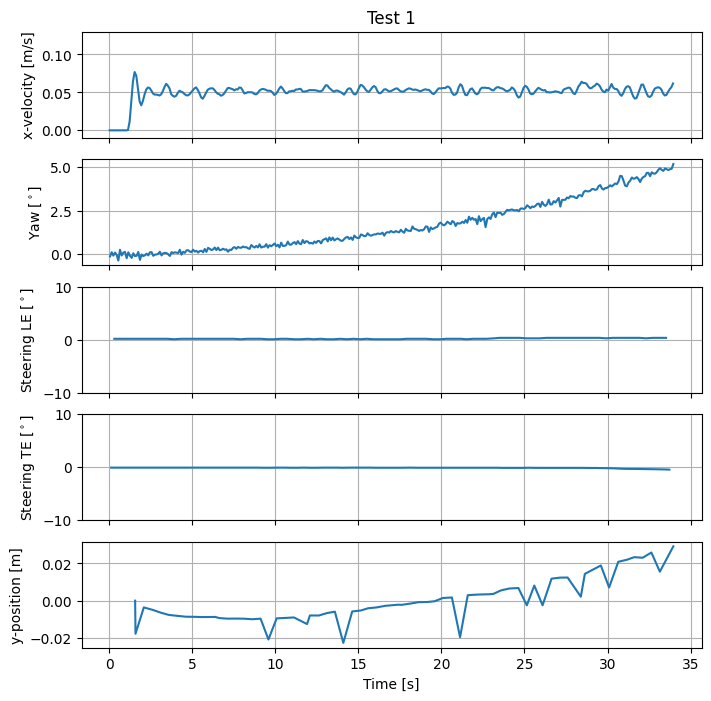

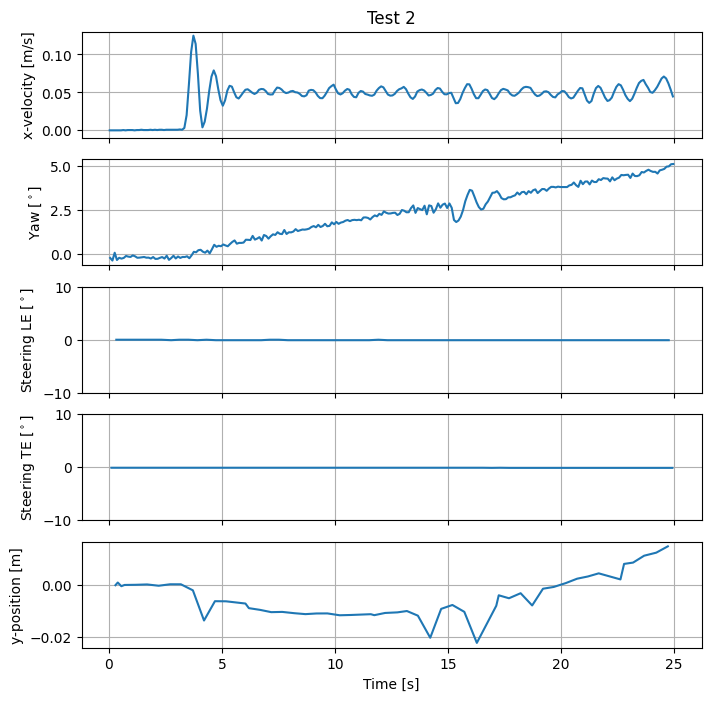

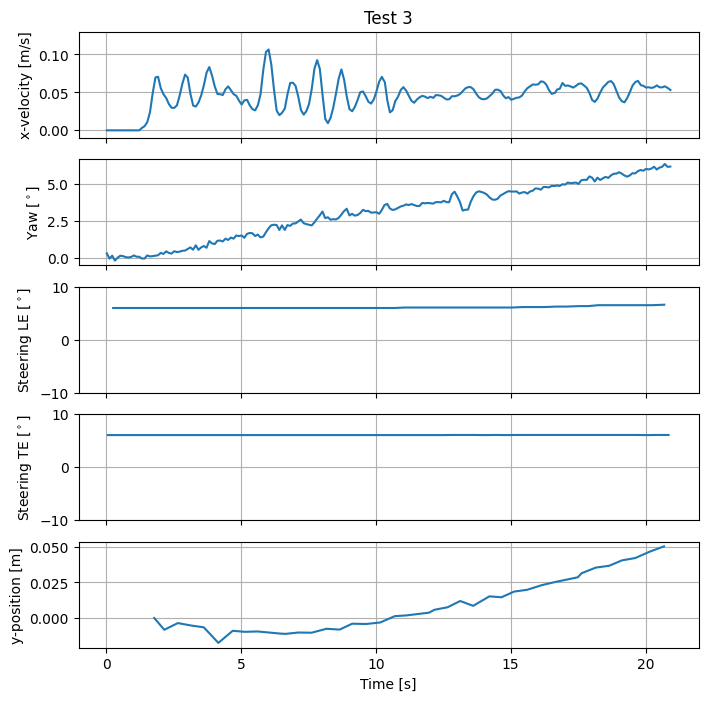

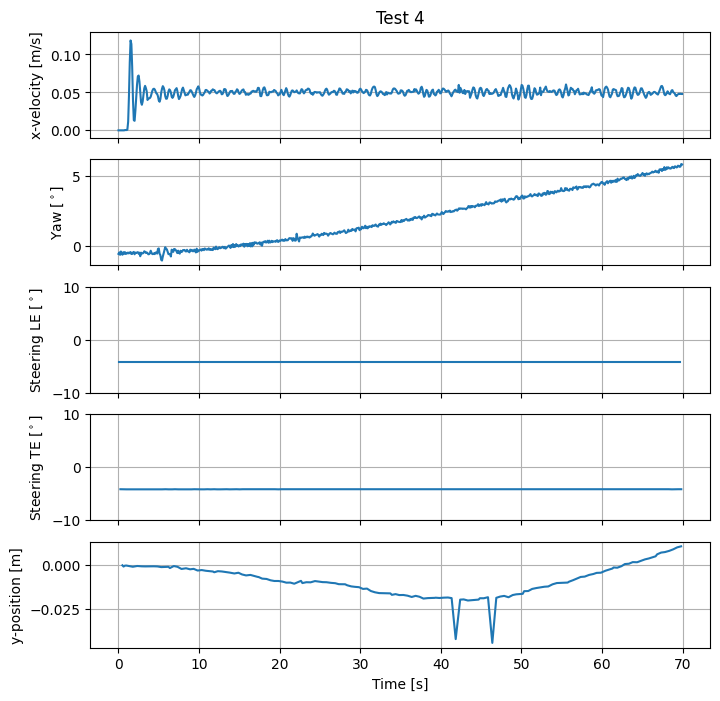

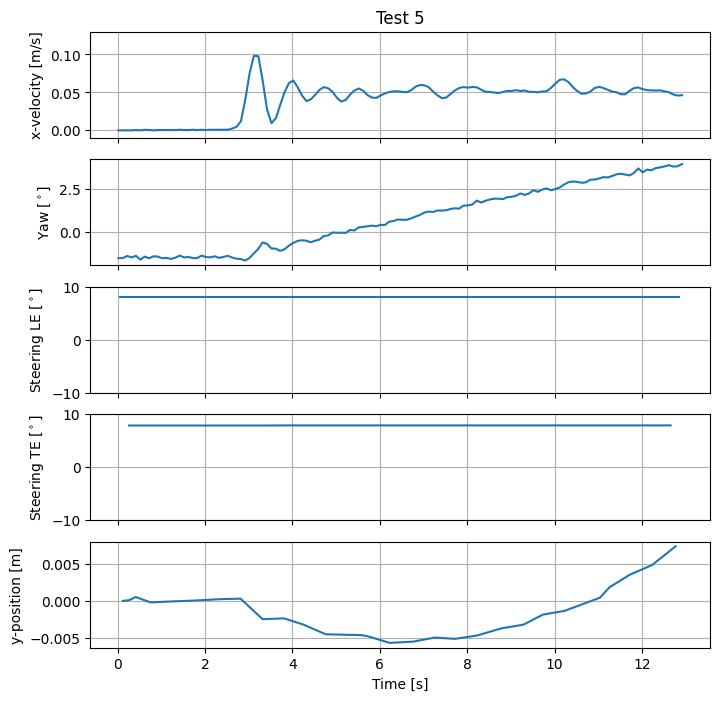

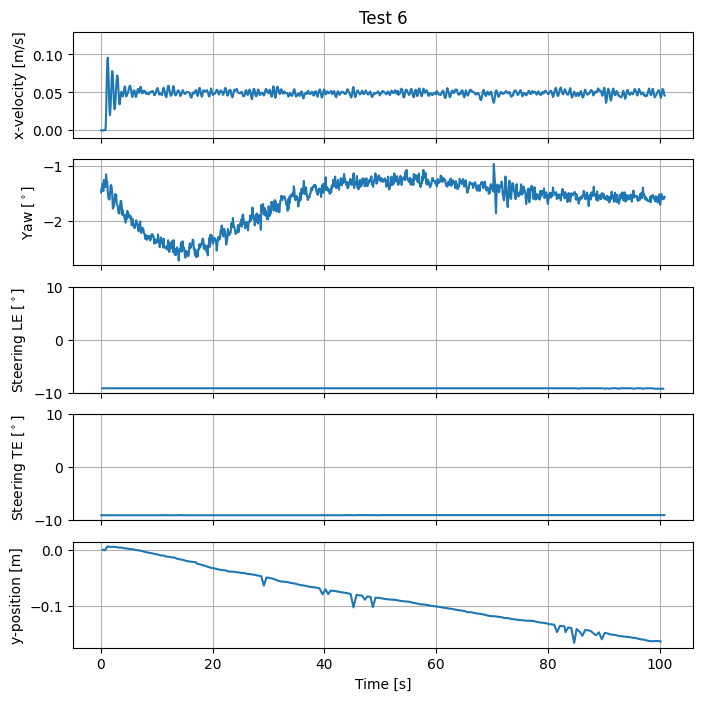

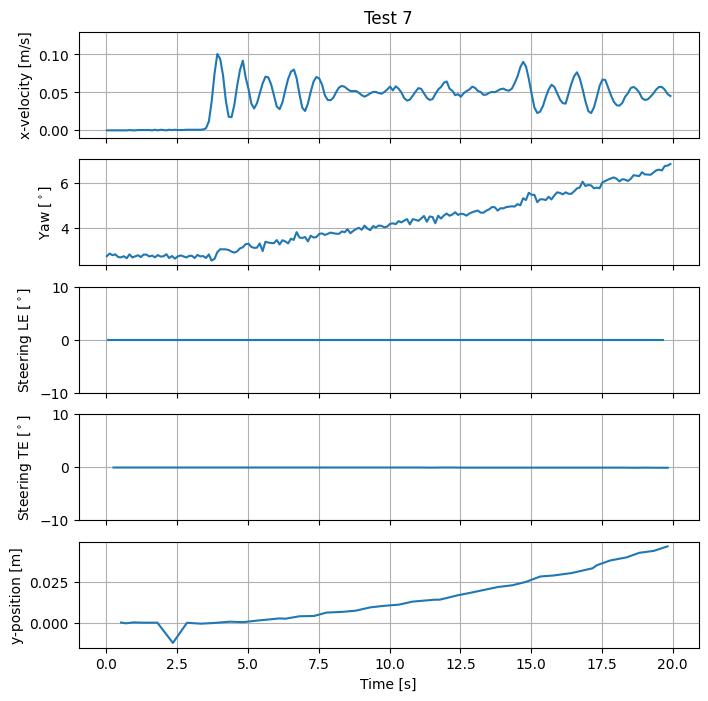

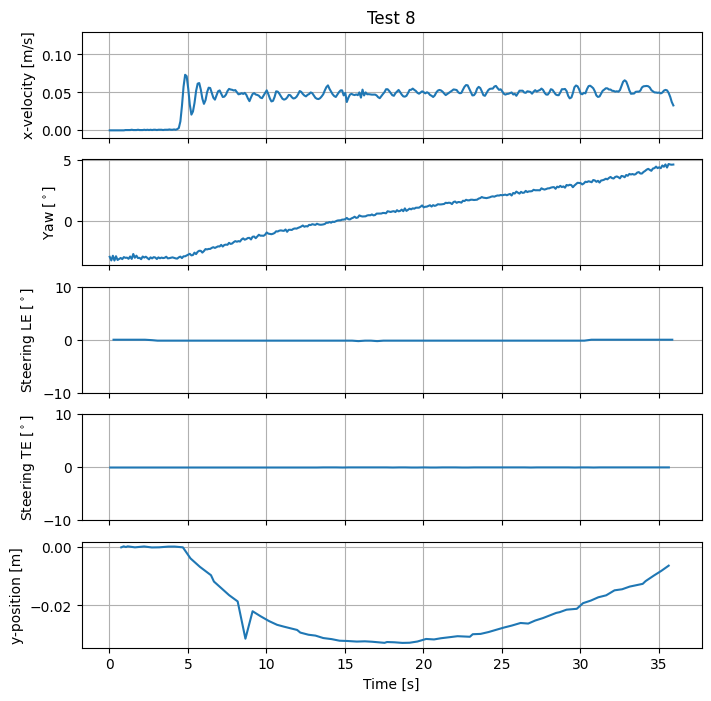

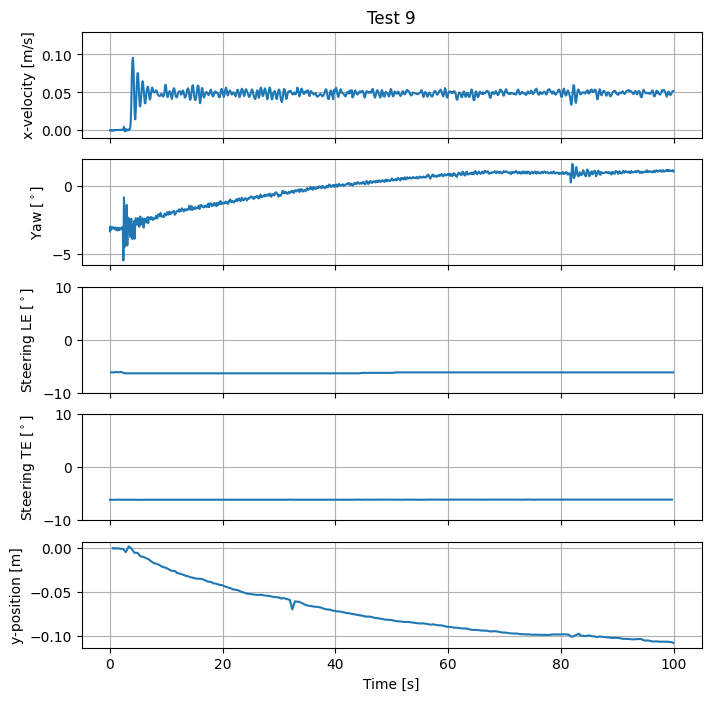

In [13]:
for i in range(0,9):
    df_plot_exp(test_starts[i], test_ends[i], df_vel_exp, df_yaw_exp, df_le_dist_exp, df_left_steer_exp, df_right_steer_exp, title=f'Test {i+1}')
    plt.savefig(f'plots/test{i+1}.png', bbox_inches='tight')

In [14]:
# Plot vel, yaw, le_dist
def df_plot_y(t_start, t_end, df_le_dist_exp, df_odom_, title=''):

    df_le_dist_timed = df_time_span(t_start, t_end, df_le_dist_exp)

    df_ypos_timed = df_le_dist_timed
    df_ypos_timed['data'] = -(df_ypos_timed['data'] - df_ypos_timed['data'].iat[0])
    
    df_odom_['Time'] = df_odom_['Time'] - df_odom_['Time'].iat[0]

    df_odom_['pose.pose.position.y'] = df_odom_['pose.pose.position.y'] - df_odom_['pose.pose.position.y'].iat[0]

    #fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,4), sharex=True)
    #df_ypos_timed.plot(x='Time', xlabel='Time', y='data', ylabel='Y-position test [m]', legend=False, ax=axes[0])
    #df_odom_.plot(x='Time', xlabel='Time', y='pose.pose.position.y', ylabel='Y-position simulation [m]', legend=False, ax=axes[1])
    
    ax = df_ypos_timed.plot(x='Time', xlabel='Time [s]', y='data', grid=True, ylabel='y-position [m]', figsize=(8,3), title=title)
    df_odom_.plot(x='Time', xlabel='Time [s]', y='pose.pose.position.y', grid=True, ylabel='y-position [m]', ax=ax)
    ax.legend(["Test", "Simulation"])

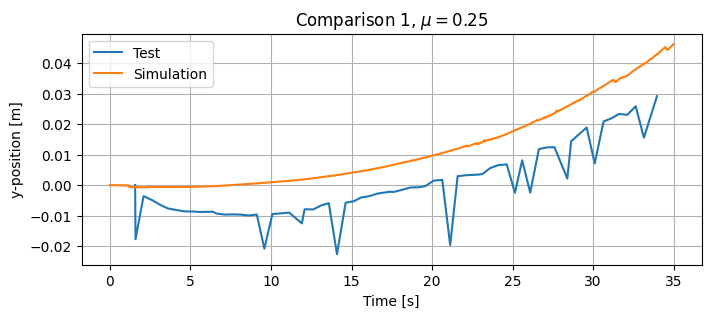

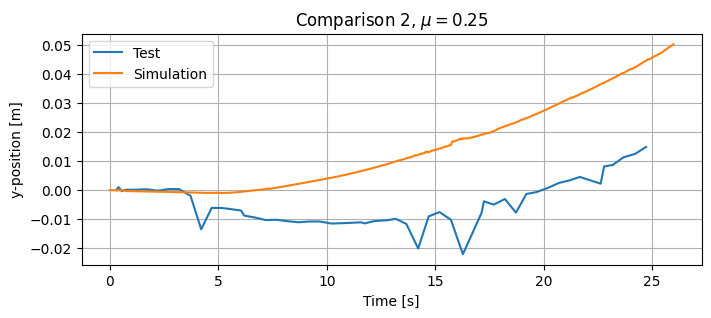

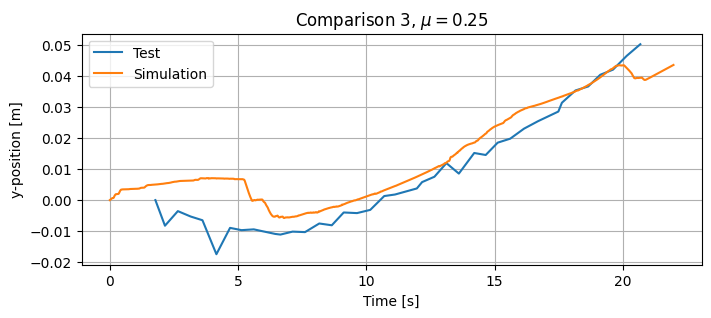

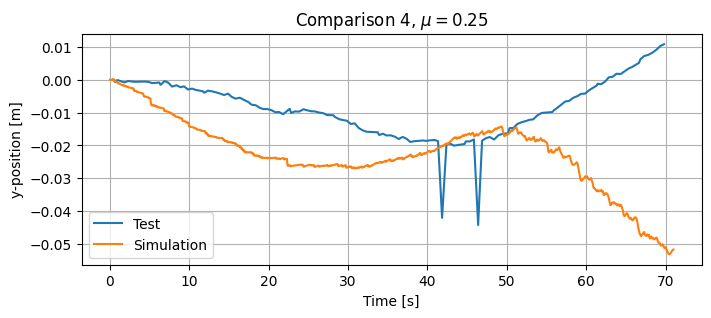

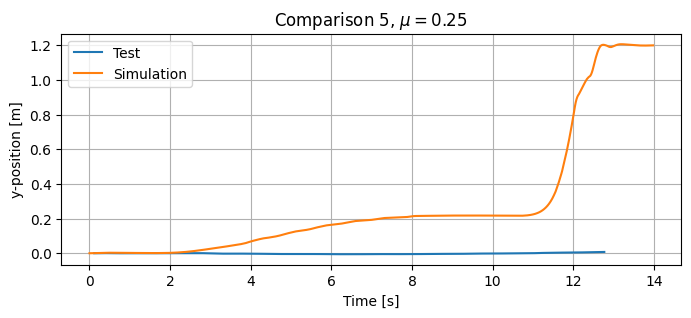

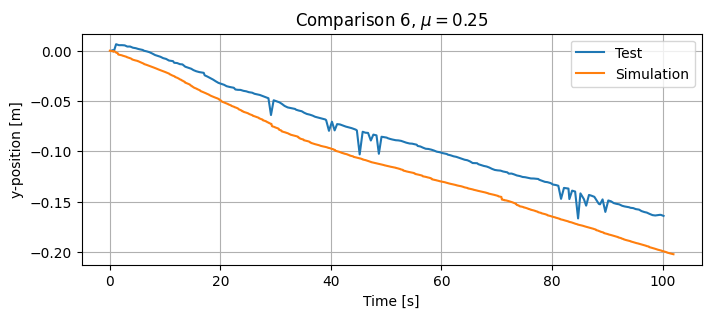

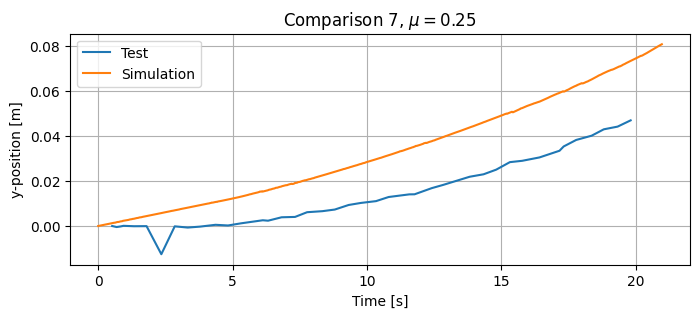

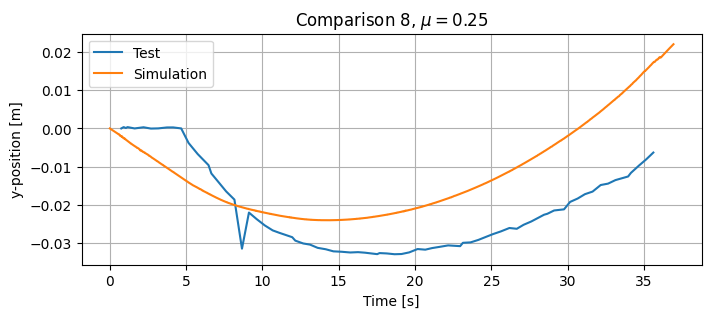

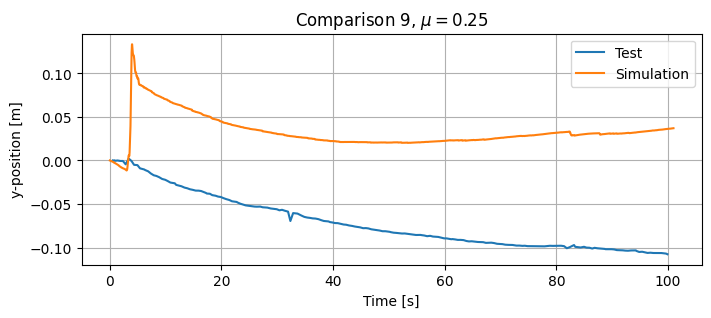

In [15]:
for i in range(0,9):
    df_plot_y(test_starts[i], test_ends[i], df_le_dist_exp, df_odom[i], title=f'Comparison {i+1}, $\mu=0.25$')
    plt.savefig(f'plots/comparison{i+1}.png', bbox_inches='tight')

In [16]:
# Plot vel, yaw, le_dist
def df_plot_y_offset(t_start, t_end, df_le_dist_exp, df_odom_, off_set, title=''):

    df_le_dist_timed = df_time_span(t_start, t_end, df_le_dist_exp)

    df_ypos_timed = df_le_dist_timed
    df_ypos_timed['data'] = -(df_ypos_timed['data'] - df_ypos_timed['data'].iat[0])
    
    df_odom_['Time'] = df_odom_['Time'] - df_odom_['Time'].iat[0] + off_set[0]

    df_odom_['pose.pose.position.y'] = df_odom_['pose.pose.position.y'] - df_odom_['pose.pose.position.y'].iat[0] + off_set[1]

    #fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,4), sharex=True)
    #df_ypos_timed.plot(x='Time', xlabel='Time', y='data', ylabel='Y-position test [m]', legend=False, ax=axes[0])
    #df_odom_.plot(x='Time', xlabel='Time', y='pose.pose.position.y', ylabel='Y-position simulation [m]', legend=False, ax=axes[1])
    
    ax = df_ypos_timed.plot(x='Time', xlabel='Time [s]', y='data', grid=True, ylabel='y-position [m]', figsize=(8,3), title=title)
    df_odom_.plot(x='Time', xlabel='Time [s]', y='pose.pose.position.y', grid=True, ylabel='y-position [m]', ax=ax)
    ax.legend(["Test", "Simulation"])

In [17]:
off_set = [[0,-0.01], [3.5,-0.01], [0.5,0], [0,0], [0,0], [1,0.01], [1,-0.01], [4.5,0], [0,-0.1]]

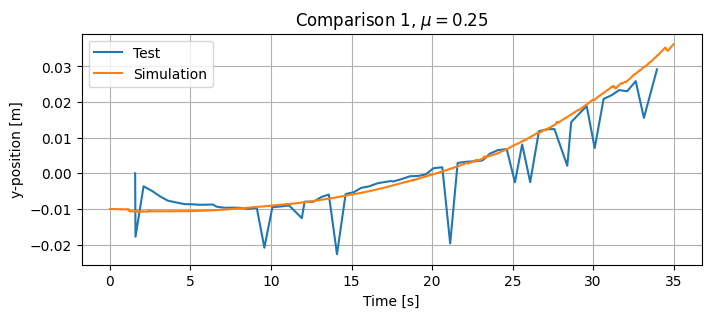

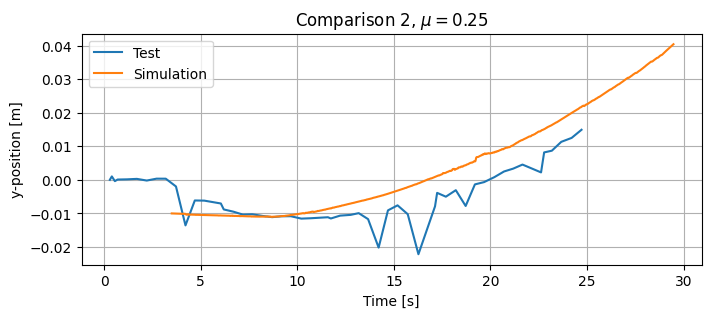

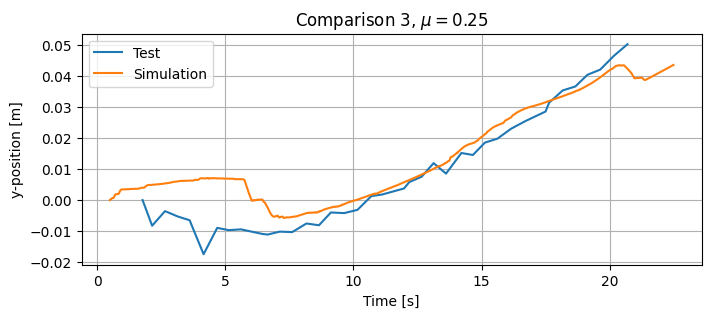

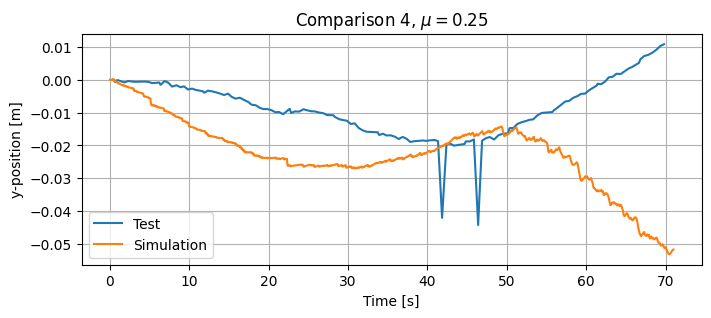

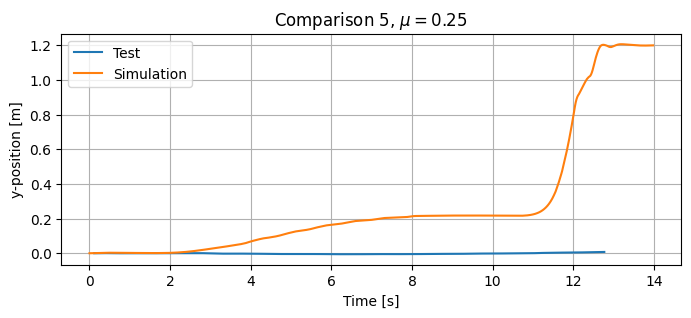

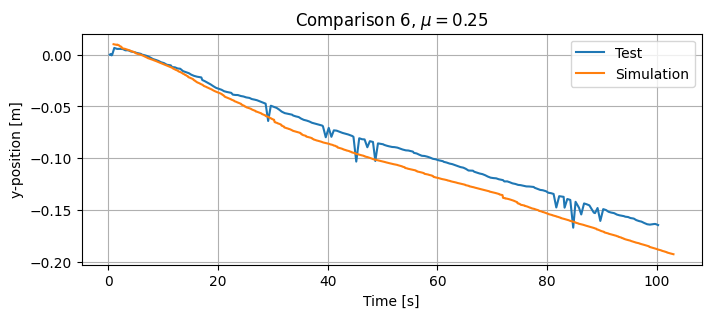

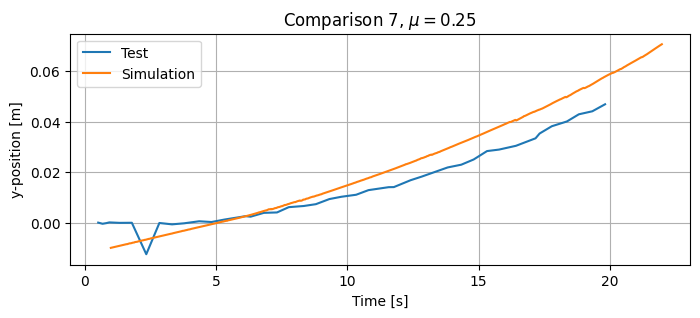

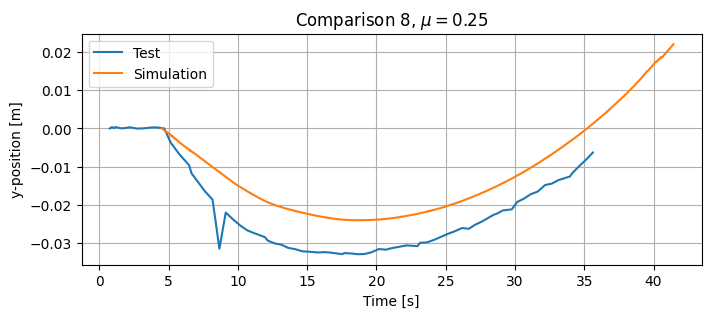

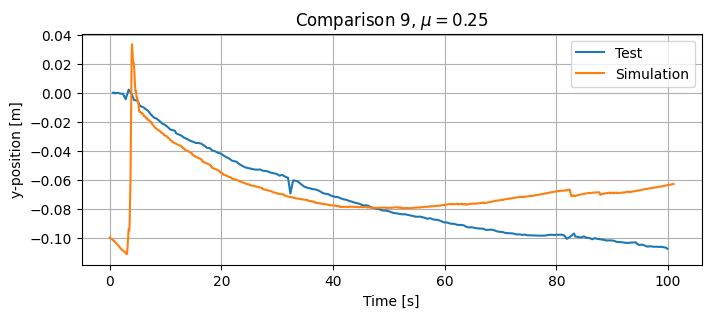

In [18]:
for i in range(0,9):
    df_plot_y_offset(test_starts[i], test_ends[i], df_le_dist_exp, df_odom[i], off_set[i], title=f'Comparison {i+1}, $\mu=0.25$')
    plt.savefig(f'plots/comparison{i+1}_offset.png', bbox_inches='tight')

In [19]:
VAC1 = b_exp1.message_by_topic("/vacuum_system/status_string")
VAC2 = b_exp2.message_by_topic("/vacuum_system/status_string")

df_vac_exp1 = pd.read_csv(VAC1)
df_vac_exp2 = pd.read_csv(VAC2)

df_vac_exp = df_vac_exp1.append(df_vac_exp2)

In [20]:
pd.set_option('display.max_columns', None)
df_vac_exp

,Time,data
0,1.682071e+09,\n edge_vacuum: VAC 12.3%\n center_vacuum: V...
1,1.682071e+09,\n edge_vacuum: VAC 12.3%\n center_vacuum: V...
2,1.682071e+09,\n edge_vacuum: VAC 12.3%\n center_vacuum: V...
3,1.682071e+09,\n edge_vacuum: VAC 12.3%\n center_vacuum: V...
4,1.682071e+09,\n edge_vacuum: VAC 12.3%\n center_vacuum: V...
...,...,...
11617,1.682081e+09,\n edge_vacuum: AMB 0.4%\n center_vacuum: AM...
11618,1.682081e+09,\n edge_vacuum: AMB 0.4%\n center_vacuum: AM...
11619,1.682081e+09,\n edge_vacuum: AMB 0.3%\n center_vacuum: AM...
11620,1.682081e+09,\n edge_vacuum: AMB 0.4%\n center_vacuum: AM...


In [21]:
#import csv
#for i in range(0,9):
#    df_vac_timed = df_time_span(test_starts[i], test_ends[i], df_vac_exp)
#    df_vac_extract = df_vac_timed.copy()

#    df_vac_extract['Time'] = df_vac_timed['Time']
#    df_vac_extract['data'] = df_vac_timed['data'].str.findall(r'\d+(?:\.\d+)?').apply(','.join)
#    df_vac_extract.to_csv(f'src/verification_controller/src/vac{i+1}.csv', index=False, escapechar="\\",  quoting=csv.QUOTE_NONE)


[INFO]  Data folder rosbag_sim/sim1_mu5 already exists. Not creating.


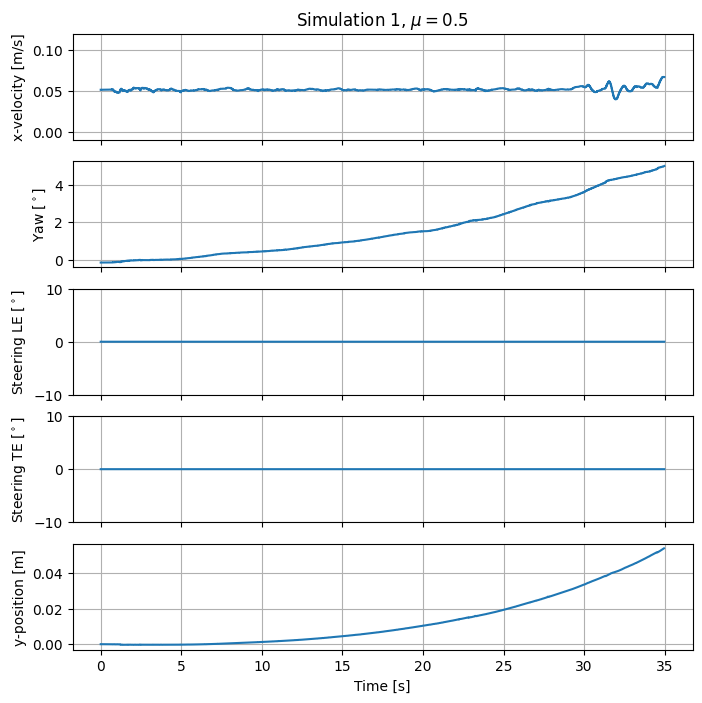

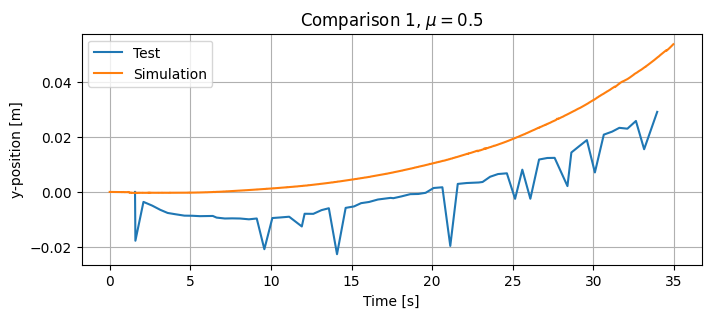

In [22]:
df_vel_1, df_yaw_1, df_odom_1, df_joint_1 = df_sim('rosbag_sim/sim1_mu5.bag')

df_plot(df_vel_1, df_yaw_1, df_odom_1, df_joint_1, title=f'Simulation 1, $\mu=0.5$')

df_plot_y_offset(test_starts[0], test_ends[0], df_le_dist_exp, df_odom_1, [0,0], title=f'Comparison 1, $\mu=0.5$')
plt.savefig(f'plots/comparison_sim1_mu0.5.png', bbox_inches='tight')

[INFO]  Data folder rosbag_sim/sim1_mu5 already exists. Not creating.


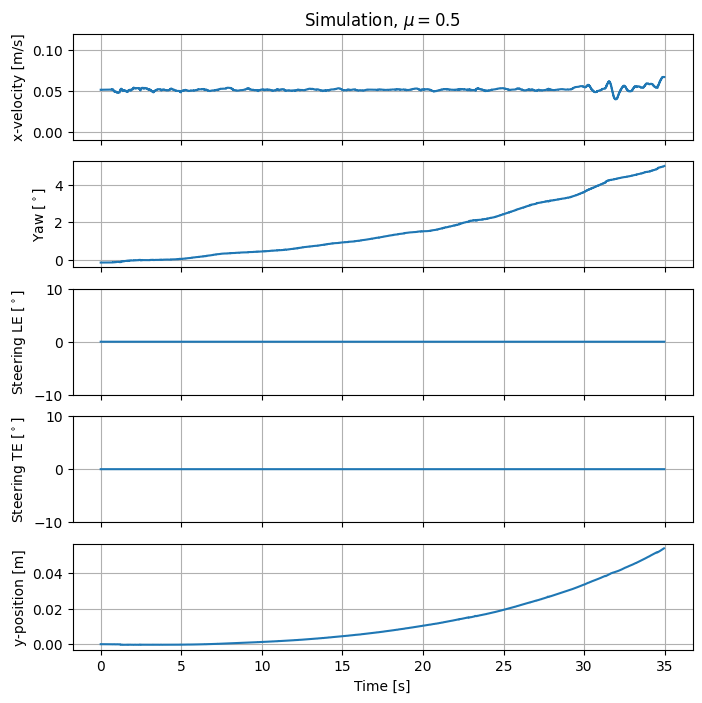

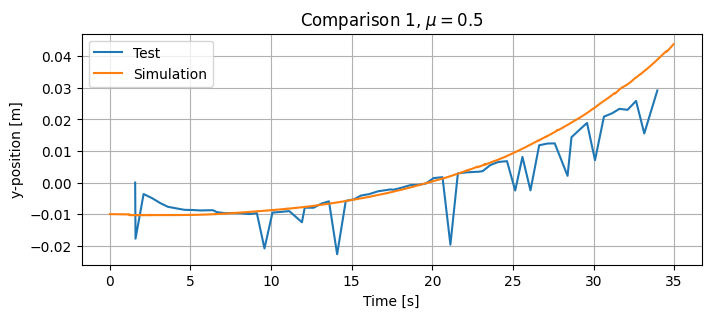

In [23]:
df_vel_1, df_yaw_1, df_odom_1, df_joint_1 = df_sim('rosbag_sim/sim1_mu5.bag')

df_plot(df_vel_1, df_yaw_1, df_odom_1, df_joint_1, title=f'Simulation, $\mu=0.5$')

df_plot_y_offset(test_starts[0], test_ends[0], df_le_dist_exp, df_odom_1, [0,-0.01], title=f'Comparison 1, $\mu=0.5$')
plt.savefig(f'plots/comparison_sim1_mu0.5_offset.png', bbox_inches='tight')

[INFO]  Data folder rosbag_sim/sim5_mu15 already exists. Not creating.


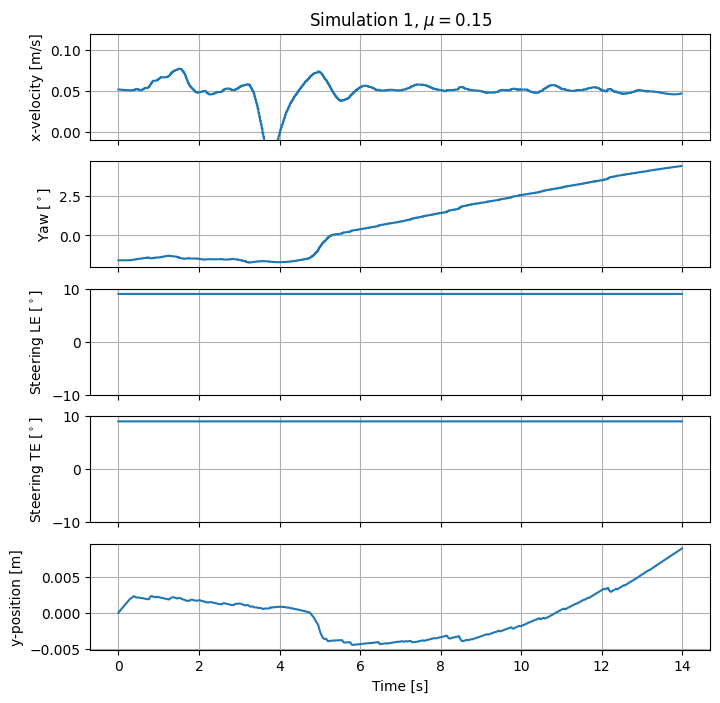

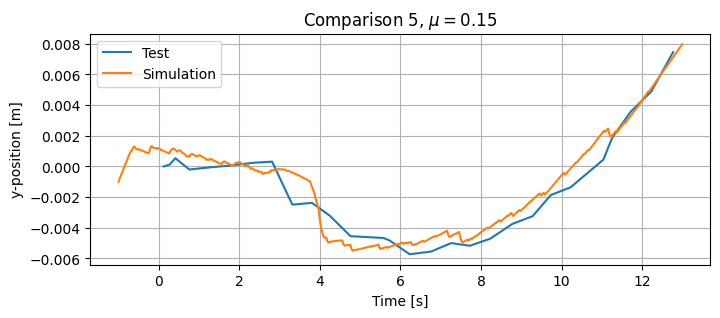

In [24]:
mu = 0.15

df_vel_1, df_yaw_1, df_odom_1, df_joint_1 = df_sim('rosbag_sim/sim5_mu15.bag')

df_plot(df_vel_1, df_yaw_1, df_odom_1, df_joint_1, title=f'Simulation 1, $\mu={mu}$')

df_plot_y_offset(test_starts[4], test_ends[4], df_le_dist_exp, df_odom_1, [-1,-0.001], title=f'Comparison 5, $\mu={mu}$')
plt.savefig(f'plots/comparison5_mu{mu}_offset.png', bbox_inches='tight')

In [25]:
# Plot vel, yaw, le_dist
def df_plot_yaw(t_start, t_end, df_yaw_exp, df_yaw_, title=''):

    df_yaw_timed = df_time_span(t_start, t_end, df_yaw_exp)
    
    df_yaw_['Time'] = df_yaw_['Time'] - df_yaw_['Time'].iat[0]

    df_yaw_deg = df_yaw_.copy()

    df_yaw_deg['data'] = df_yaw_deg['data']*180/3.14
    
    ax = df_yaw_timed.plot(x='Time', xlabel='Time [s]', y='euler_angles.yaw', grid=True, ylabel='Yaw [$^\circ$]', figsize=(8,3), title=title)
    df_yaw_deg.plot(x='Time', xlabel='Time [s]', y='data', grid=True, ylabel='Yaw [$^\circ$]', ax=ax)
    ax.legend(["Test", "Simulation"])

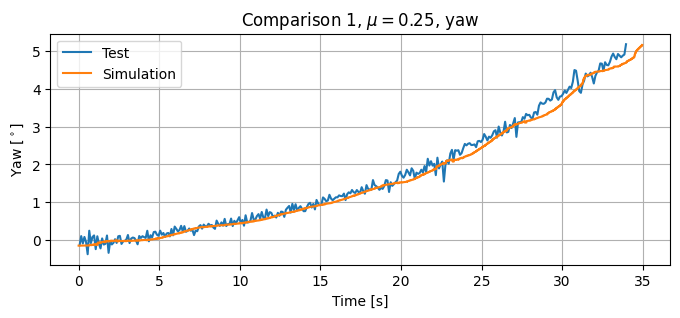

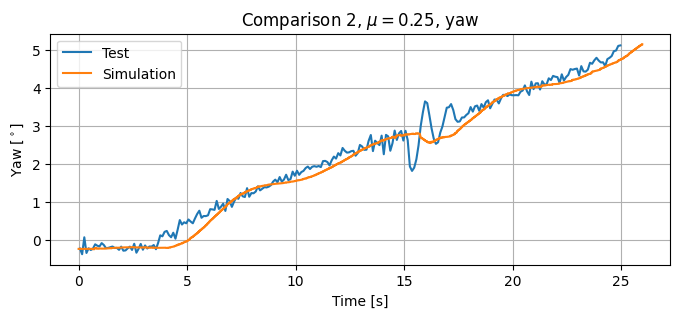

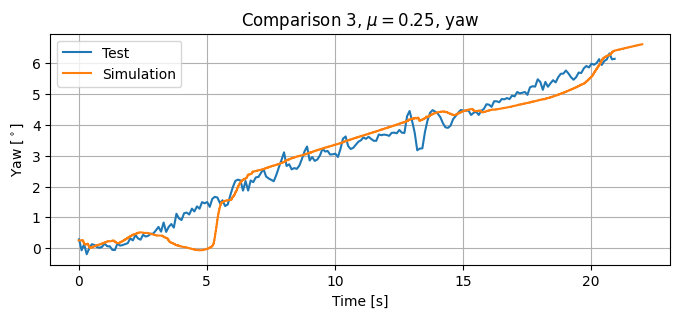

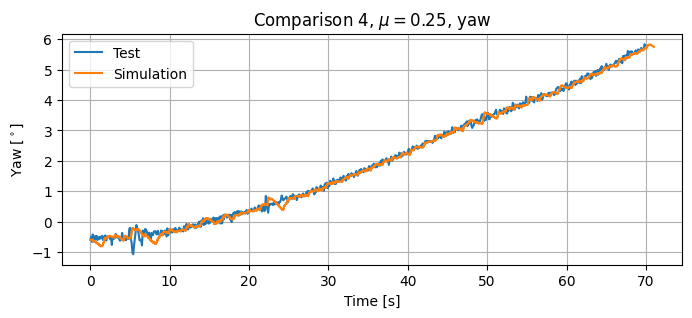

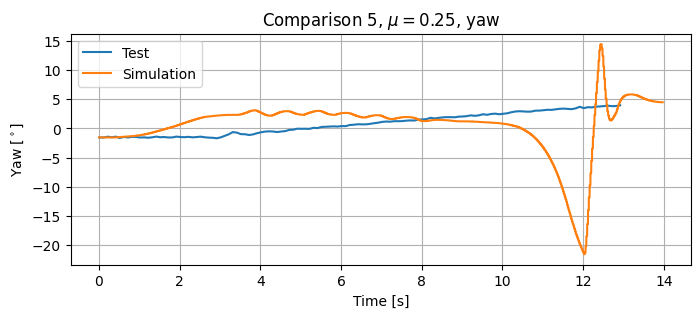

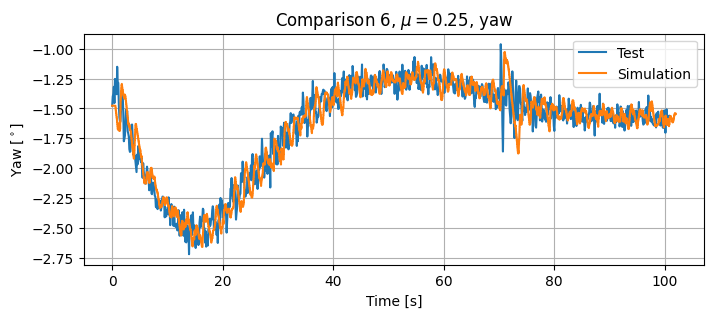

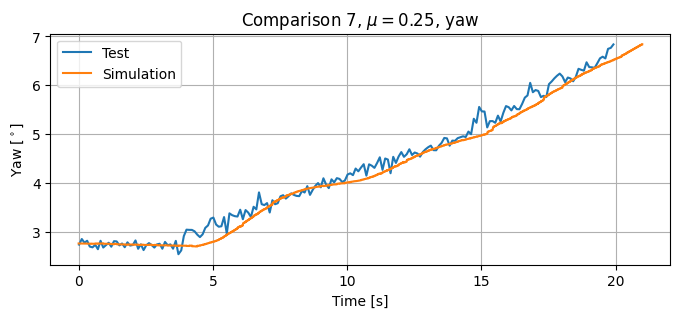

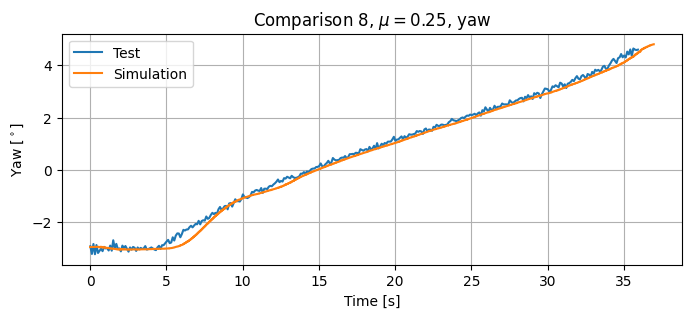

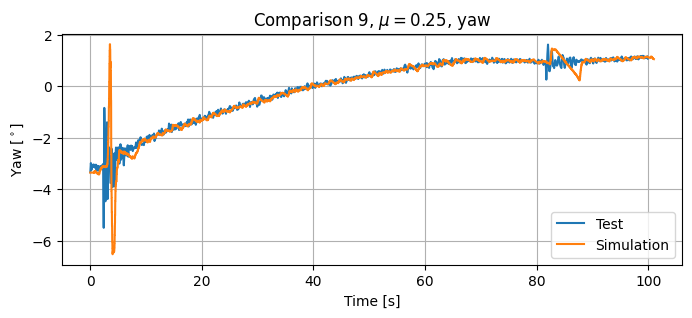

In [26]:
for i in range(0,9):
    df_plot_yaw(test_starts[i], test_ends[i], df_yaw_exp, df_yaw[i], title=f'Comparison {i+1}, $\mu=0.25$, yaw')
    plt.savefig(f'plots/comparison{i+1}_yaw.png', bbox_inches='tight')

[INFO]  Data folder rosbag_sim/sim1_mu5 already exists. Not creating.


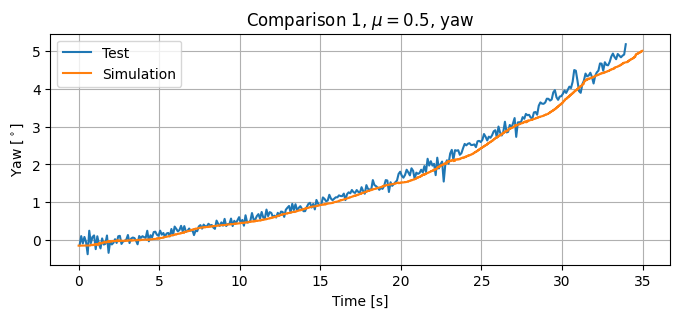

In [27]:
df_vel_1, df_yaw_1, df_odom_1, df_joint_1 = df_sim('rosbag_sim/sim1_mu5.bag')

df_plot_yaw(test_starts[0], test_ends[0], df_yaw_exp, df_yaw_1, title=f'Comparison 1, $\mu=0.5$, yaw')
plt.savefig(f'plots/comparison1_yaw_mu0.5.png', bbox_inches='tight')

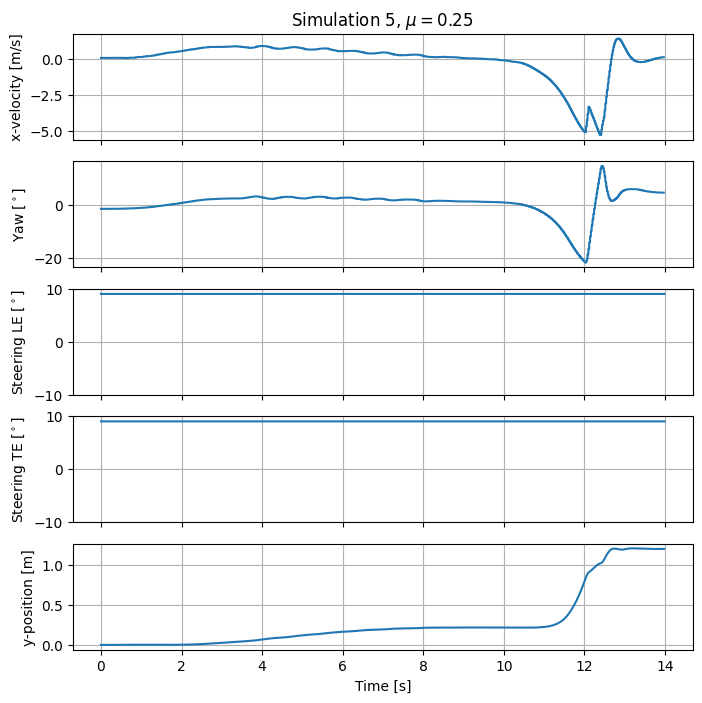

In [29]:
# Plot vel, yaw, le_dist
def df_plot(df_vel_, df_yaw_, df_odom_, df_joint_, title=''):

    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8,8), sharex=True)

    df_vel_['Time'] = df_vel_['Time'] - df_vel_['Time'].iat[0]
    df_yaw_['Time'] = df_yaw_['Time'] - df_yaw_['Time'].iat[0]
    df_odom_['Time'] = df_odom_['Time'] - df_odom_['Time'].iat[0]
    df_joint_['Time'] = df_joint_['Time'] - df_joint_['Time'].iat[0]

    df_yaw_deg = df_yaw_.copy()
    df_joint_deg = df_joint_.copy()

    df_yaw_deg['data'] = df_yaw_deg['data']*180/3.14
    df_joint_deg['position_13'] = df_joint_deg['position_13']*180/3.14
    df_joint_deg['position_14'] = df_joint_deg['position_14']*180/3.14

    df_odom_['pose.pose.position.y'] = df_odom_['pose.pose.position.y'] - df_odom_['pose.pose.position.y'].iat[0]

    df_vel_.plot(x='Time', xlabel='Time [s]', y='data', ylabel='x-velocity [m/s]', grid=True, legend=False, ax=axes[0], title=title)
    df_yaw_deg.plot(x='Time', xlabel='Time [s]', y='data', ylabel='Yaw [$^\circ$]', grid=True, legend=False, ax=axes[1])
    df_joint_deg.plot(ylim=[-10, 10], x='Time', xlabel='Time [s]', y='position_13', ylabel='Steering LE [$^\circ$]', grid=True, legend=False, ax=axes[2])
    df_joint_deg.plot(ylim=[-10, 10], x='Time', xlabel='Time [s]', y='position_14', ylabel='Steering TE [$^\circ$]', grid=True, legend=False, ax=axes[3])
    df_odom_.plot(x='Time', xlabel='Time [s]', y='pose.pose.position.y', ylabel='y-position [m]', legend=False, grid=True, ax=axes[4])

df_plot(df_vel[4], df_yaw[4], df_odom[4], df_joint[4], title=f'Simulation 5, $\mu=0.25$')
plt.savefig(f'plots/sim5.png', bbox_inches='tight')